### Feature Engineering Overview

This notebook performs the feature engineering process on the *Loan Portfolio* dataset.  
The objective is to transform and enrich the raw dataset prepared during the EDA stage to support subsequent KPI calculation and portfolio analysis.  
No predictive modeling is applied — all transformations are aimed at improving data quality, interpretability, and aggregation readiness.


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
import category_encoders as ce


In [38]:
# Create a working copy
fe = df.copy() 
print("Start shape:", fe.shape)

Start shape: (10000, 128)


### Ordinal Feature Encoding

Ordinal variables such as **loan term**, **employment length**, **grade**, and **sub-grade** are converted to numeric scales.  
This enables consistent quantitative analysis while preserving their inherent order relationships.


In [39]:
#Ordinal encodings (term, emp_length, grade, sub_grade)

# term → numeric months
if 'term' in fe.columns:
    fe['term_months'] = (
        fe['term'].astype(str).str.extract(r'(\d+)')[0].astype(float)
    ).astype('float32')

# emp_length → years (e.g., "< 1 year" -> 0, "10+ years" -> 10)
if 'emp_length' in fe.columns:
    def emp_len_to_years(x: str) -> float:
        if x is None or (isinstance(x, float) and np.isnan(x)): 
            return np.nan
        x = str(x).strip().lower()
        if x.startswith('<'):
            return 0.0
        m = re.search(r'(\d+)', x)
        if m:
            val = float(m.group(1))
            return 10.0 if '+' in x else val
        return np.nan
    fe['emp_length_years'] = fe['emp_length'].apply(emp_len_to_years).astype('float32')

# grade → ordinal (A..G). Higher is better risk-wise (A highest)
if 'grade' in fe.columns:
    grade_order = {'g':1,'f':2,'e':3,'d':4,'c':5,'b':6,'a':7}
    fe['grade_ord'] = fe['grade'].astype(str).str.lower().map(grade_order).astype('float32')

# sub_grade → ordinal A1..G5 → 1..35 (higher = better)
if 'sub_grade' in fe.columns:
    def subgrade_to_ord(x: str) -> float:
        if not isinstance(x, str) or len(x) < 2:
            return np.nan
        letter, num = x[0].upper(), x[1:]
        if letter not in 'ABCDEFG' or not num.isdigit():
            return np.nan
        base = (ord(letter) - ord('A')) * 5
        return float(base + int(num))  # A1..A5: 1..5, B1..B5: 6..10, ... G1..G5: 31..35
    fe['sub_grade_ord'] = fe['sub_grade'].apply(subgrade_to_ord).astype('float32')

added = [c for c in fe.columns if c.endswith(('_months','_years','_ord'))]
print("Added (ordinal):", added)
print("Shape:", fe.shape)


Added (ordinal): ['term_months', 'emp_length_years', 'grade_ord', 'sub_grade_ord']
Shape: (10000, 132)


### Date Decomposition

Date fields (e.g., issue date, last payment date, settlement date) are decomposed into separate **year** and **month** components.  
This transformation allows time-based grouping, trend analysis, and the derivation of temporal metrics such as credit history age.


In [40]:
# Date decomposition (year, month, optional ages)

date_cols = [
    'issue_d','earliest_cr_line','last_pymnt_d',
    'next_pymnt_d','last_credit_pull_d',
    'debt_settlement_flag_date','settlement_date',
    'sec_app_earliest_cr_line'
]

# LendingClub dates look like "Dec-2015"
FMT = "%b-%Y"

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)  # silence the “Could not infer format” spam
    for col in date_cols:
        if col in fe.columns:
            # strip just in case and parse with explicit format
            dt = pd.to_datetime(fe[col].astype(str).str.strip(), format=FMT, errors="coerce")
            fe[col + "_year"]  = dt.dt.year.astype("float32")
            fe[col + "_month"] = dt.dt.month.astype("float32")

print("Done parsing year/month. Shape:", fe.shape)

Done parsing year/month. Shape: (10000, 148)


### Derived Time Feature: Credit History Age

A new variable `credit_history_age_months` is computed as the difference in months between the loan issue date and the borrower's earliest credit line.  
This feature measures the borrower’s credit experience and is useful for portfolio risk and maturity analysis.


In [ ]:
# credit history age in months

issue_col = 'issue_d'
earliest_col = 'earliest_cr_line'

# Explicit date parsing with format "%b-%Y"
issue_dt = pd.to_datetime(fe[issue_col].astype(str).str.strip(), format="%b-%Y", errors="coerce")
earl_dt  = pd.to_datetime(fe[earliest_col].astype(str).str.strip(), format="%b-%Y", errors="coerce")

# Create mask for valid rows
mask = issue_dt.notna() & earl_dt.notna()

# Initialize column
fe['credit_history_age_months'] = np.nan

# Calculate difference in months
months_diff = (
    (issue_dt.dt.year[mask] - earl_dt.dt.year[mask]) * 12
    + (issue_dt.dt.month[mask] - earl_dt.dt.month[mask])
).astype('float32')

# Assign and clean negatives
fe.loc[mask, 'credit_history_age_months'] = months_diff
fe.loc[fe['credit_history_age_months'] < 0, 'credit_history_age_months'] = np.nan

print("Added credit_history_age_months. Shape:", fe.shape)

Added credit_history_age_months. Shape: (10000, 160)


### Numeric Feature Transformations

Numeric variables are standardized and transformed to improve interpretability and reduce skewness.  
Transformations include:
- **Log scaling** for highly skewed financial amounts  
- **Ratio features** (e.g., payment-to-loan ratio, income-to-loan ratio)  
- **Standard scaling** for comparability across KPIs


In [45]:
# numeric feature transformation

# Select numeric features for transformation
num_cols = fe.select_dtypes(include=['float64', 'int64']).columns

# Log transform for skewed features (add +1 to avoid log(0))
log_features = ['loan_amnt', 'annual_inc', 'total_pymnt', 'total_rec_int', 'funded_amnt_inv']
for col in log_features:
    if col in fe.columns:
        fe[col + '_log'] = np.log1p(fe[col])

# Ratio features (relative to loan amount)
if all(c in fe.columns for c in ['total_pymnt', 'loan_amnt']):
    fe['payment_to_loan_ratio'] = fe['total_pymnt'] / fe['loan_amnt']

if all(c in fe.columns for c in ['annual_inc', 'loan_amnt']):
    fe['income_to_loan_ratio'] = fe['annual_inc'] / fe['loan_amnt']

# Standard scaling
scaler = StandardScaler()
scaled_features = ['int_rate', 'installment', 'annual_inc', 'dti']
for col in scaled_features:
    if col in fe.columns:
        fe[col + '_scaled'] = scaler.fit_transform(fe[[col]])

print("Added numeric transformations. Shape:", fe.shape)


Added numeric transformations. Shape: (10000, 160)


### Categorical Feature Encoding

Categorical attributes are encoded as follows:
- **Low-cardinality** variables (≤10 unique values) use one-hot encoding.  
- **High-cardinality** variables use target encoding with respect to `loan_status`.  

This ensures an optimal balance between interpretability and dimensionality.


In [47]:
# categorical encoding

# Identify categorical columns
cat_cols = fe.select_dtypes(include=['object']).columns
print("Total categorical columns:", len(cat_cols))

# Split categorical columns by unique count
low_card_cols = [c for c in cat_cols if fe[c].nunique() <= 10]
high_card_cols = [c for c in cat_cols if fe[c].nunique() > 10]

print("Low-cardinality cols:", len(low_card_cols))
print("High-cardinality cols:", len(high_card_cols))

# One-hot encoding for low-cardinality
fe = pd.get_dummies(fe, columns=low_card_cols, drop_first=True)

# Target encoding for high-cardinality
if 'loan_status' in fe.columns:
    target_col = 'loan_status'
else:
    target_col = fe.columns[-1]  # fallback if loan_status not found

encoder = ce.TargetEncoder(cols=high_card_cols)
fe[high_card_cols] = encoder.fit_transform(fe[high_card_cols], fe[target_col])

print("Encoded categorical features. Shape:", fe.shape)

Total categorical columns: 29
Low-cardinality cols: 13
High-cardinality cols: 16
Encoded categorical features. Shape: (10000, 176)


### Feature selection & export ###

#### Correlation inspection (for data validation only) ####


Correlation matrix shape: (126, 126)


,loan_amnt,int_rate,annual_inc,dti,term_months,emp_length_years,total_pymnt,revol_util
loan_amnt,1.000,0.093,0.469,0.059,0.440,0.077,0.640,0.115
int_rate,0.093,1.000,-0.132,0.183,0.370,-0.009,0.070,0.287
annual_inc,0.469,-0.132,1.000,-0.189,0.135,0.130,0.317,0.090
dti,0.059,0.183,-0.189,1.000,0.080,0.048,0.014,0.162
term_months,0.440,0.370,0.135,0.080,1.000,0.048,0.213,0.072
emp_length_years,0.077,-0.009,0.130,0.048,0.048,1.000,0.072,0.039
total_pymnt,0.640,0.070,0.317,0.014,0.213,0.072,1.000,0.191
revol_util,0.115,0.287,0.090,0.162,0.072,0.039,0.191,1.000


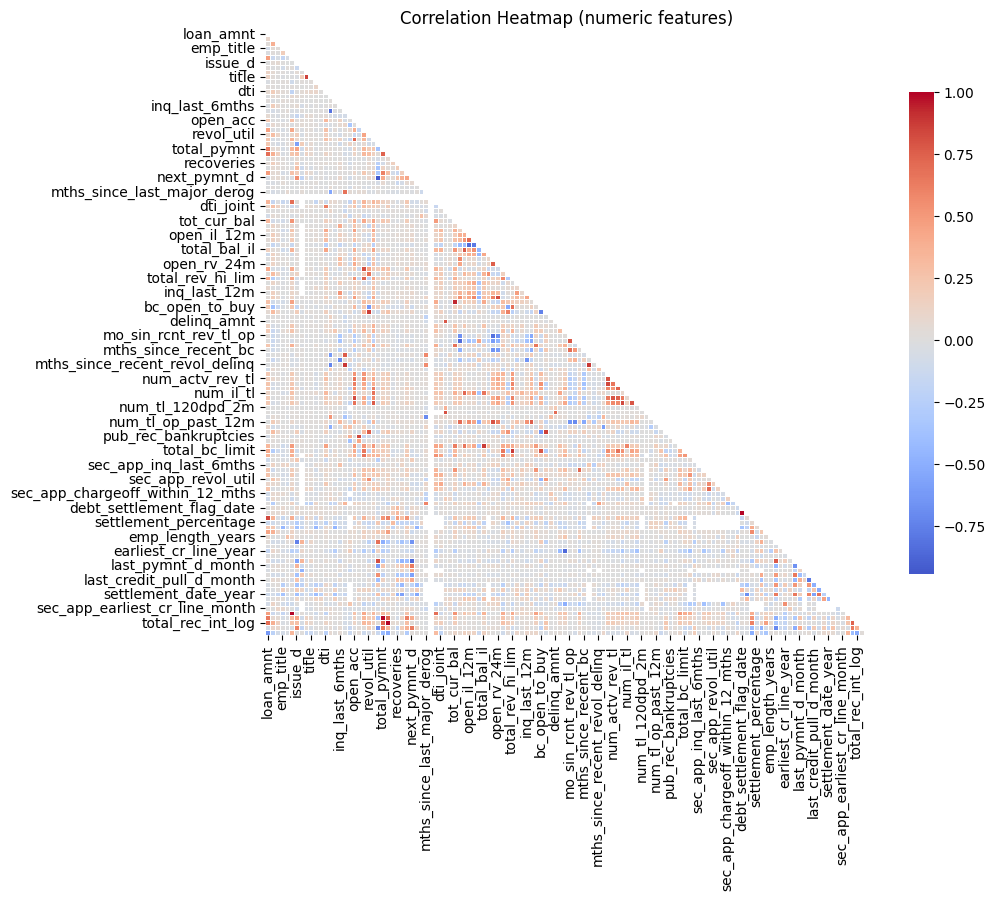

In [51]:
# 1) build corr on numeric columns only
num_cols = fe.select_dtypes(include=np.number).columns
corr = fe[num_cols].corr(method="spearman", min_periods=50)

print(f"Correlation matrix shape: {corr.shape}")

# 2) show a small, valid sample (only columns that actually exist)
sample_cols = [
    "loan_amnt", "int_rate", "installment", "annual_inc", "dti",
    "term_months", "emp_length_years", "total_pymnt", "revol_util"
]
sample_cols = [c for c in sample_cols if c in corr.columns]

if sample_cols:
    display(corr.loc[sample_cols, sample_cols].round(3))
else:
    print("No sample columns found among numeric features.")

# 3) heatmap with guard against all-NaN
calc = corr.to_numpy()
if np.all(np.isnan(calc)):
    print("All correlations are NaN (likely no numeric overlap). Nothing to plot.")
else:
    # upper-triangle mask
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # robust limits ignoring NaNs
    vmin = np.nanmin(calc)
    vmax = np.nanmax(calc)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = -1, 1  # fallback

    plt.figure(figsize=(11, 9))
    sns.heatmap(
        corr, mask=mask, cmap="coolwarm", center=0,
        vmin=vmin, vmax=vmax, square=True, linewidths=.5,
        cbar_kws={"shrink": .8}
    )
    plt.title("Correlation Heatmap (numeric features)")
    plt.tight_layout()
    plt.show()

### Correlation Analysis (Validation Step)

A correlation matrix was computed across all **numeric features** to inspect potential multicollinearity within the dataset.  
The following heatmap provides an overview of relationships between key quantitative variables (e.g., `loan_amnt`, `int_rate`, `annual_inc`, `total_pymnt`, etc.).  
No variables were removed, as this analysis serves **data understanding** rather than feature selection for modeling.  
High correlations will, however, be documented for potential aggregation or normalization in subsequent KPI calculations.


In [52]:
# --- Export engineered dataset for KPI computation ---

fe.to_csv("loan_portfolio_featured.csv", index=False)
print("Exported cleaned and engineered dataset:", fe.shape)

Exported cleaned and engineered dataset: (10000, 155)


### Summary

The feature-engineered dataset includes all transformed variables (ordinal, numeric, temporal, and categorical).  
It will be used as the foundation for KPI calculation and aggregation in the **Loan Portfolio Monitoring** pipeline.
